In [248]:
import numpy as np
from IPython.display import clear_output
from time import sleep
from colorama import Fore, Back, Style
from matplotlib import pyplot as plt

## Maze Environment class
MazeEnv implements environment for reinforecement q-learning task. It creates a maze based on input data. Function `step(action)` does transition from one state to another, returns new state, reward of action in current state and information wheater finish spot has been achieved.

In [249]:
class MazeEnv:
    def __init__(self, map):
        self.map = self.get_map(map)
        self.rows_num, self.cols_num = self.map.shape
        self.columns_num = len(map[0])
        self.rows_num = len(map)
        self.actions = {0: "south", 1: "north", 2: "east", 3: "west"}
        self.rewards = {" ": -1, "S": -1,"#": -10, "F": 20}
        self.states = self.get_states()
        self.state = self.states[self.get_start()][0]
        self.loc = self.decode_state(self.state)
    
        num_states = self.rows_num*self.cols_num
        num_actions = len(self.actions)
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }

    def get_start(self):
        row, col = np.where(self.map == "S")
        return row, col
    
    def get_finish(self):
        row, col = np.where(self.map == "F")
        return row, col
    
    def get_map(self, map):
        spots = []
        for row in map:
            for spot in row:
                spots.append(spot)
        return np.reshape(spots, (len(map), len(map[0])))
    
    def get_states(self):
        num_states = self.rows_num*self.cols_num
        states = [num for num in range(num_states)]
        return np.reshape(states, (self.rows_num, self.cols_num))
        
    def print_map(self):
        map_copy = np.ndarray.tolist(self.map)
        if self.loc == self.get_start():
            map_copy[self.loc[0]][self.loc[1]] = Back.GREEN + 'S' + Style.RESET_ALL
        elif self.loc == self.get_finish():
            map_copy[self.loc[0]][self.loc[1]] = Back.GREEN + 'F' + Style.RESET_ALL
        else:
            map_copy[self.loc[0]][self.loc[1]] = Back.GREEN + ' ' + Style.RESET_ALL
        for row in map_copy:
            to_print = ""
            for spot in row:
                to_print += spot
            print(to_print)
            
    def print_map_road(self, coords):
        map_copy = np.ndarray.tolist(self.map)
        for coord in coords:
            map_copy[coord[0]][coord[1]] = Fore.GREEN + 'o' + Style.RESET_ALL
        for row in map_copy:
            to_print = ""
            for spot in row:
                to_print += spot
            print(to_print)
            
    def step(self, a):
    
        max_row = self.rows_num - 1
        max_col = self.columns_num - 1
        wall = '#'
        new_row, new_col = self.loc
        reward = -1  # default reward
        done = False
        (row, col) = self.loc

        if action == 0:
            if self.map[min(row + 1, max_row)][col] != '#':
                new_row = min(row + 1, max_row)
            else: reward = -10
        elif action == 1:
            if self.map[max(row - 1, 0)][col] != '#':
                new_row = max(row - 1, 0)
            else: reward = -10
        if action == 2:
            if self.map[row][min(col + 1, max_col)] != '#':
                new_col = min(col + 1, max_col)
            else: reward = -10
        elif action == 3:
            if self.map[row][max(col - 1, 0)] != '#':
                new_col = max(col - 1, 0)
            else: reward = -10

        if (new_row, new_col) == self.get_finish():
            done = True
            reward = 20

        new_state = self.encode_state(new_row, new_col)
        self.state = new_state
        self.loc = (new_row, new_col)
        
        return new_state, reward, done

    
    def encode_state(self, current_row, current_col):
        state = current_row*self.columns_num + current_col
        return state
    
    def decode_state(self, state):
        row = int(state / self.columns_num)
        col = state - row*self.columns_num
        return row, col
    
    def reset(self):
        self.state = self.states[self.get_start()][0]
        self.loc = self.decode_state(self.state)
        return self.state

 ## Example 1

In [250]:
map =  ["#############",
        "#  #       S#",
        "#  #  #######",
        "#           #",
        "#######  #  #",
        "#  #     #  #",
        "#  #  #  #  #",
        "#     #  # F#",
        "#############"]

env = MazeEnv(map)
env.print_map()

#############
#  #       S#
#  #  #######
#           #
#######  #  #
#  #     #  #
#  #  #  #  #
#     #  # F#
#############


### Training the agent - updating Q-Table based on state, action in that state and reward for it
#### Params: `alpha = 0.1`, `gamma = 0.6`, `epsilon = 0.1`
#### Number of episodes: `1001`

In [256]:
q_table = np.zeros([env.columns_num*env.rows_num, 4])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 1001):
    
    state = env.reset()
    epochs, penalties, reward = (0, 0, 0)
    done = False

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, 3)  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        ## DISPLAY MAP WHILE LEARNING  <---   <---   <---   <---  <---   <---
#         sleep(0.01)
#         env.print_map()
#         print('Steps: ', epochs)
#         print('Epoch: ', i)
#         print('Penalties: ', penalties)
#         clear_output(wait=True)

    all_penalties.append(penalties)
    all_epochs.append(epochs)

    if i % 100 == 0:
        clear_output(wait=True)
        
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 1000
Training finished.



Text(0, 0.5, 'steps')

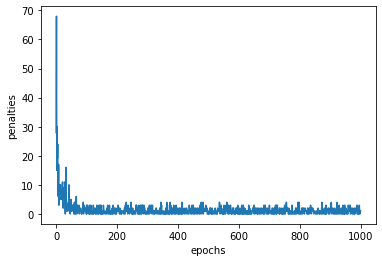

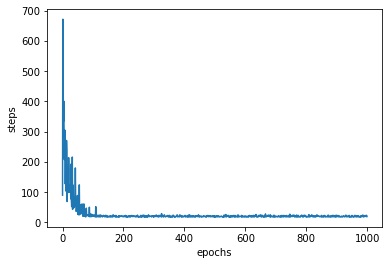

In [257]:
plt.figure(1)
plt.plot(all_penalties)
plt.xlabel('epochs')
plt.ylabel('penalties')
plt.figure(2)
plt.plot(all_epochs)
plt.xlabel('epochs')
plt.ylabel('steps')

### Evaluate agent's performance after Q-learning

In [258]:
total_epochs, total_penalties = 0, 0
episodes = 5

for _ in range(episodes):
    coords = []
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[env.state])
        next_state, reward, done = env.step(action)
        coords.append(env.loc)

        if reward == -10:
            penalties += 1
        epochs += 1

        env.print_map()
        sleep(.1)
        clear_output(wait=True)
        print('Action: ', env.actions[action])
        print('Steps :', epochs)

    total_penalties += penalties
    total_epochs += epochs
clear_output(wait=True)
env.print_map_road(coords)
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

#############
#  # ooooooS#
#  # o#######
#    oooooo #
#######  #oo#
#  #     # o#
#  #  #  # o#
#     #  # o#
#############
Results after 5 episodes:
Average timesteps per episode: 18.0
Average penalties per episode: 0.0


## Example 2 - bigger map

In [259]:
map =  ['#########################',
        '#S             #     #  #',
        '#  ##########  ####  #  #',
        '#     #  #           #  #',
        '#  #  #  ####  #######  #',
        '#  #     #  #     #     #',
        '#  ####  #  #  #  #  #  #',
        '#  #        #  #     #  #',
        '#  ####  #############  #',
        '#  #                 #  #',
        '#######  #  #######  #  #',
        '#  #  #  #  #  #     #  #',
        '#  #  ####  #  ####  ####',
        '#           #  #     #  #',
        '####  #  ####  #  ####  #',
        '#     #     #          F#',
        '#########################']

env = MazeEnv(map)
env.print_map()

#########################
#S             #     #  #
#  ##########  ####  #  #
#     #  #           #  #
#  #  #  ####  #######  #
#  #     #  #     #     #
#  ####  #  #  #  #  #  #
#  #        #  #     #  #
#  ####  #############  #
#  #                 #  #
#######  #  #######  #  #
#  #  #  #  #  #     #  #
#  #  ####  #  ####  ####
#           #  #     #  #
####  #  ####  #  ####  #
#     #     #          F#
#########################


#### Training the agent - updating Q-Table based on state, action in that state and reward for it
##### Params: `alpha = 0.1`, `gamma = 0.6`, `epsilon = 0.1`
##### Number of episodes: `1001`

In [264]:
q_table = np.zeros([env.columns_num*env.rows_num, 4])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 1001):
    
    state = env.reset()
    epochs, penalties, reward = (0, 0, 0)
    done = False

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, 3)  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        ## DISPLAY MAP WHILE LEARNING  <---   <---   <---   <---  <---   <---
#         sleep(0.01)
#         env.print_map()
#         print('Steps: ', epochs)
#         print('Epoch: ', i)
#         print('Penalties: ', penalties)
#         clear_output(wait=True)

    all_penalties.append(penalties)
    all_epochs.append(epochs)

    if i % 100 == 0:
        clear_output(wait=True)
        
        print(f"Epoch: {i}")

print("Training finished.\n")

Epoch: 1000
Training finished.



Text(0, 0.5, 'steps')

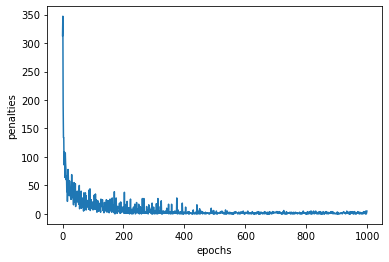

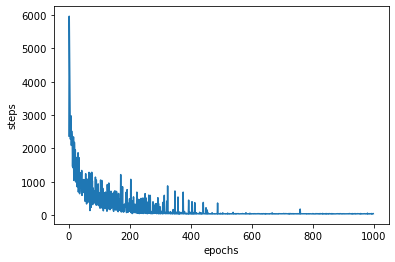

In [265]:
plt.figure(1)
plt.plot(all_penalties)
plt.xlabel('epochs')
plt.ylabel('penalties')
plt.figure(2)
plt.plot(all_epochs)
plt.xlabel('epochs')
plt.ylabel('steps')

##### Evaluate agent's performance after Q-learning

In [266]:
total_epochs, total_penalties = 0, 0
episodes = 3

for _ in range(episodes):
    coords = []
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[env.state])
        next_state, reward, done = env.step(action)
        coords.append(env.loc)
        

        if reward == -10:
            penalties += 1
        epochs += 1

        env.print_map()
        sleep(.1)
        clear_output(wait=True)
        print('Action: ', env.actions[action])
        print('Steps :', epochs)

    total_penalties += penalties
    total_epochs += epochs
clear_output(wait=True)
env.print_map_road(coords)
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

#########################
#S             #     #  #
#oo##########  ####  #  #
# ooo #  #           #  #
#  #oo#  ####  #######  #
#  # ooo #  #     #     #
#  ####o #  #  #  #  #  #
#  #   o    #  #     #  #
#  ####oo#############  #
#  #    oooooooooooo #  #
#######  #  #######o #  #
#  #  #  #  #  #   o #  #
#  #  ####  #  ####o ####
#           #  # ooo #  #
####  #  ####  # o####  #
#     #     #    ooooooo#
#########################
Results after 3 episodes:
Average timesteps per episode: 40.0
Average penalties per episode: 0.0
